<a href="https://colab.research.google.com/github/tnfru/colab_research/blob/master/CIFAR10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import sys
if 'google.colab' in sys.modules:
  %tensorflow_version 2.x
import tensorflow as tf
from google.colab import drive
from sklearn.utils import shuffle
from keras.utils.np_utils import to_categorical
from keras.datasets import cifar10
from keras import regularizers

AUTO = tf.data.experimental.AUTOTUNE

TensorFlow 2.x selected.


Using TensorFlow backend.


## Set up TPU and GPU usage

In [2]:
try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
except ValueError:
  tpu = None
  gpus = tf.config.experimental.list_logical_devices("GPU")

if tpu:
  tf.config.experimental_connect_to_cluster(tpu)
  tf.tpu.experimental.initialize_tpu_system(tpu)
  strategy = tf.distribute.experimental.TPUStrategy(tpu)
  print('Running on TPU ', tpu.master())  
elif len(gpus) > 0:
  strategy = tf.distribute.MirroredStrategy(gpus)
  print('Running on ', len(gpus), ' GPU(s) ')
else:
  strategy = tf.distribute.get_strategy()
  print('Running on CPU')

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Running on  1  GPU(s) 


## Read data

In [0]:
IMG_SIZE = [32, 32]
BATCH_SIZE = 128

In [0]:
(X, Y), (X_test, Y_test) = cifar10.load_data()
Y = to_categorical(Y, num_classes=10)
Y_test = to_categorical(Y_test, num_classes=10)

In [5]:
X.shape, Y.shape, X_test.shape, Y_test.shape

((50000, 32, 32, 3), (50000, 10), (10000, 32, 32, 3), (10000, 10))

## Zero center and scale to unit variance

In [6]:
np.isnan(X).sum(), np.isnan(X_test).sum()

(0, 0)

In [0]:
X = X / 255.0
X_test = X_test / 255.0
X = X - X.mean(axis=0)
X_test = X_test - X_test.mean(axis=0)

In [8]:
X.mean()

-1.2150526510860496e-14

In [0]:
X = X / X.std(axis=0)
X_test = X_test / X_test.std(axis=0)

In [10]:
X.std(axis=0).sum() / (32 * 32 * 3)

1.000000000000001

## Convert Data to batches

In [0]:
def data_augment(image, label):
  image = tf.image.random_flip_left_right(image)
  image = tf.image.random_saturation(image, lower=0, upper=2)
  return image, label

In [0]:
def get_batched_dataset(dataset, train=False):
  if train:
    dataset = dataset.repeat()
    dataset = dataset.map(data_augment, num_parallel_calls=AUTO)
    dataset = dataset.shuffle(1337)

  dataset = dataset.batch(BATCH_SIZE)
  dataset = dataset.prefetch(AUTO)
  return dataset

In [0]:
train_dataset = tf.data.Dataset.from_tensor_slices((X, Y))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, Y_test))

train = get_batched_dataset(train_dataset, train=True)
test = get_batched_dataset(test_dataset)

In [0]:
l = tf.keras.layers

## LeNet5 architecture

In [0]:
def create_model():
  model = tf.keras.Sequential([
    l.Conv2D(kernel_size=3, filters=16, padding='same', activation='relu', input_shape=(*IMG_SIZE, 3)),
    l.BatchNormalization(),
    l.Conv2D(kernel_size=3, filters=32, padding='same', activation='relu'),
    l.BatchNormalization(),
    l.MaxPooling2D(),
    l.Dropout(0.5),

    l.Conv2D(kernel_size=3, filters=64, padding='same', activation='relu'),
    l.BatchNormalization(),
    l.Conv2D(kernel_size=3, filters=64, padding='same', activation='relu'),
    l.BatchNormalization(),
    l.MaxPooling2D(),
    l.Dropout(0.5),
    
    l.Conv2D(kernel_size=3, filters=128, padding='same', activation='relu'),
    l.BatchNormalization(),
    l.Conv2D(kernel_size=3, filters=128, padding='same', activation='relu'),
    l.BatchNormalization(),
    l.MaxPooling2D(),
    l.Dropout(0.5),

    l.Conv2D(kernel_size=3, filters=128, padding='same', activation='relu'),
    l.BatchNormalization(),
    l.Flatten(),
    l.Dense(10, activation='softmax')
  ])

  model.compile(
      optimizer='adam',
      loss='categorical_crossentropy',
      metrics=['accuracy']
  )

  return model

## Architecture inspired by Inception

In [0]:
def lr_fun(x):
  if x > 20:
    return 5e-4
    
  return 1e-3

In [0]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=10,
    horizontal_flip=True,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1
)
datagen.fit(X)

In [0]:
def inception(x, squeeze, expand):
  y_1 = l.Conv2D(filters=squeeze, kernel_size=1, padding='same',activation='elu')(x)
  y_1 = l.BatchNormalization()(y_1)
  y_1 = l.Conv2D(filters=expand//4, kernel_size=3, padding='same',activation='elu')(y_1)
  y_1 = l.BatchNormalization()(y_1)

  y_2 = l.Conv2D(filters=squeeze, kernel_size=1, padding='same',activation='elu')(x)
  y_2 = l.BatchNormalization()(y_2)
  y_2 = l.Conv2D(filters=expand//4, kernel_size=5, padding='same',activation='elu')(y_2)
  y_2 = l.BatchNormalization()(y_2)

  y_3 = l.Conv2D(filters=expand//4, kernel_size=1, padding='same',activation='elu')(x)
  y_3 = l.BatchNormalization()(y_3)

  return l.concatenate([y_1, y_2, y_3])

def inception_module(squeeze, expand):
  return lambda x: inception(x, squeeze, expand)

In [0]:
def create_inception_net():

  x = l.Input(shape=[*IMG_SIZE, 3])
  y = l.Conv2D(filters=16, kernel_size=6, padding='same', input_shape=[*IMG_SIZE, 3])(x)
  y = l.Activation('elu')(y)
  y = l.BatchNormalization()(y)
  y = inception_module(16, 32)(y)
  y = l.MaxPooling2D()(y)
  y = l.Dropout(0.1)(y)

  y = inception_module(32, 64)(y)
  y = inception_module(64, 128)(y)
  y = l.MaxPooling2D()(y)
  y = l.Dropout(0.2)(y)
  
  y = inception_module(32, 64)(y)
  y = l.MaxPooling2D()(y)
  y = l.Dropout(0.3)(y)

  y = inception_module(16, 32)(y)
  y = l.Flatten()(y)
  y = l.Dense(10, activation='softmax')(y)

  model = tf.keras.Model(x, y)

  model.compile(
      loss='categorical_crossentropy',
      optimizer='adam',
      metrics=['accuracy']
  )

  return model

In [20]:
with strategy.scope():
  model = create_inception_net()

  model.summary()

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Redu

In [21]:
EPOCHS = 35

annealer = tf.keras.callbacks.LearningRateScheduler(lr_fun)
steps_per_epoch = X.shape[0] // BATCH_SIZE

history = model.fit(train,
                    steps_per_epoch=steps_per_epoch, 
                    epochs=EPOCHS, 
                    validation_data=test, 
                    callbacks=[annealer]
                    )

Train for 390 steps, validate for 79 steps
Epoch 1/35
390/390 [==============================] - 27s 68ms/step - loss: 1.5531 - accuracy: 0.4469 - val_loss: 1.2299 - val_accuracy: 0.5653
Epoch 2/35
390/390 [==============================] - 17s 43ms/step - loss: 1.1493 - accuracy: 0.5908 - val_loss: 1.1131 - val_accuracy: 0.6159
Epoch 3/35
390/390 [==============================] - 17s 43ms/step - loss: 1.0013 - accuracy: 0.6472 - val_loss: 0.9080 - val_accuracy: 0.6821
Epoch 4/35
390/390 [==============================] - 17s 43ms/step - loss: 0.9128 - accuracy: 0.6782 - val_loss: 0.8001 - val_accuracy: 0.7183
Epoch 5/35
390/390 [==============================] - 17s 44ms/step - loss: 0.8490 - accuracy: 0.6991 - val_loss: 0.7775 - val_accuracy: 0.7287
Epoch 6/35
390/390 [==============================] - 17s 44ms/step - loss: 0.8046 - accuracy: 0.7167 - val_loss: 0.7769 - val_accuracy: 0.7288
Epoch 7/35
390/390 [==============================] - 17s 43ms/step - loss: 0.7608 - accuracy

In [0]:
def display_training_curves(training, validation, title, subplot):
  #stolen from google cnn tutorial
  if subplot%10==1:
    plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
    plt.tight_layout()
  ax = plt.subplot(subplot)
  ax.set_facecolor('#F8F8F8')
  ax.plot(training)
  ax.plot(validation)
  ax.set_title('model '+ title)
  ax.set_ylabel(title)
  ax.set_xlabel('epoch')
  ax.legend(['train', 'valid.'])

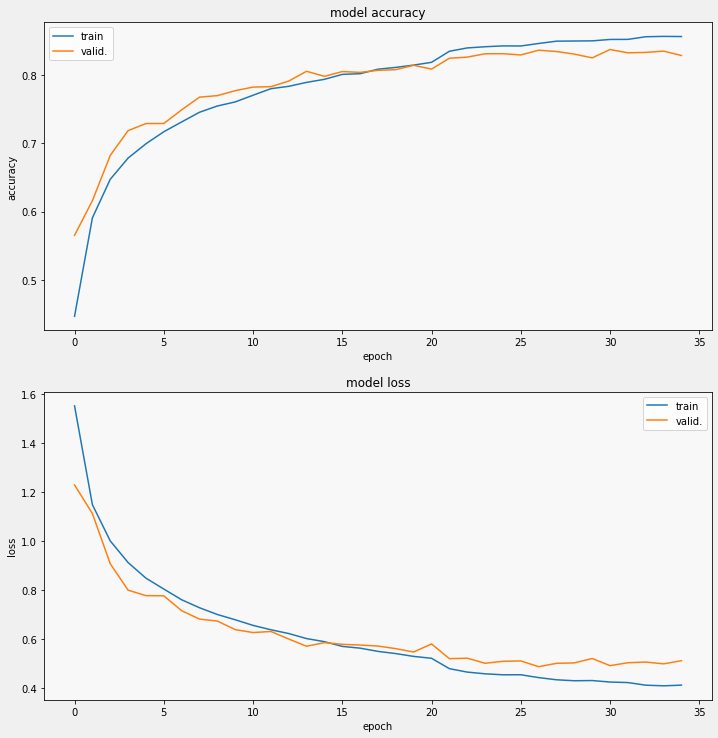

In [23]:
display_training_curves(history.history['accuracy'], history.history['val_accuracy'], 'accuracy', 211)
display_training_curves(history.history['loss'], history.history['val_loss'], 'loss', 212)

## View some examples

In [0]:
def plot_CIFAR(ind, X):
  # credit https://www.quora.com/How-can-l-visualize-cifar-10-data-RGB-using-python-matplotlib

    arr = X[ind]
    R = arr[0:1024].reshape(32,32)/255.0
    G = arr[1024:2048].reshape(32,32)/255.0
    B = arr[2048:].reshape(32,32)/255.0
 
    img = np.dstack((R,G,B))
    fig = plt.figure(figsize=(3,3))
    ax = fig.add_subplot(111)
    ax.imshow(img,interpolation='bicubic')


In [0]:
def prediction_vs_true(ind, X):
  print("Model prediction", labels[np.argmax(model.predict(X[ind].reshape(-1, 32, 32, 3)))])
  print("Correct prediction", labels[X[ind]])

In [26]:
abels = meta[b'label_names']
labels

NameError: ignored

In [0]:
plot_CIFAR(5, X)

In [0]:
prediction_vs_true(5, X)

In [0]:
plot_CIFAR(7, X)

In [0]:
prediction_vs_true(7, X)

In [0]:
plot_CIFAR(30, X)

In [0]:
prediction_vs_true(30, X)

In [0]:
plot_CIFAR(20, X)

In [0]:
prediction_vs_true(20, X)